## w-sampling

Density of w-planes varies over time, having least density at the zenith and most density as the visibility moves away from zenith.

### Goals:

- Plot density of w-term after splitting based on time

### Part -1: Splitting the Measurement Set


In [1]:
from casatools import table
from taitale.askap.tools import csimulator

import numpy as np
import os

source_ms = '1934-638_0'
ms_filename = f'{source_ms}.ms'

duration='3.5h'
# -3.5h to 3.5h
total_duration = 7

os.system("rm *.fits")
os.system(f"rm -rf {ms_filename}")

tablename = './1934-638_0.ms'

In [2]:
from taitale.askap.parsets import SourcesParset, SourceParset

# ra = '19h39m25.0267s'
# dec = '-63d42m45.6255s'
# direction=f"[{ra}, {dec}, J2000]"

# sources = SourcesParset()
# sources.add_source(SourceParset(name=source_ms, direction=direction, model="./models/1934.all.cleancomps"))

# Create Simulated dataset
csimulator(
    dataset=ms_filename,
    sourcesdef="./models/1934.all.cleancomps",
    antennas="./parsets/ASKAP36.antpos.in",
    feeds="./parsets/ASKAP1feeds.in",
    duration_from='0h',
    duration_to='7h'
)

Starting csimulator
csimulator complete


In [3]:
tbl = table()
def table_info(table_name):
    tbl.open(table_name)
    tabdesc = tbl.getdesc()
    dminfo  = tbl.getdminfo()
    tbl.close()
    return (tabdesc, dminfo)

tabdesc, dminfo = table_info(tablename)


In [4]:
from casatasks import listobs

details = listobs(tablename)

begin, end = details["BeginTime"], details["EndTime"]
begin, end

(59391.73209219876, 59392.02375886543)

In [5]:
for time_section in range(total_duration):
    tbl.open(tablename)
    t1 = tbl.query(f'TIME >= MJDTODATE({begin}) + {time_section}h and TIME <= MJDTODATE({begin}) + {time_section + 1}h')
    tbl.close()
    
    # Create a new split
    section_tbl_name = f"{source_ms}_{time_section}.ms"
    tbl.create(section_tbl_name, tabdesc, dminfo=dminfo)
    t1.copyrows(section_tbl_name, startrowout=0)
    
    tbl.close()
    t1.close()


### Part-2: Calculating density of w-terms

/home/nimalanm/Documents/casa/casa-6.3.0-48/lib/py/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


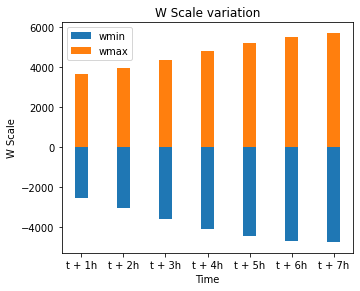

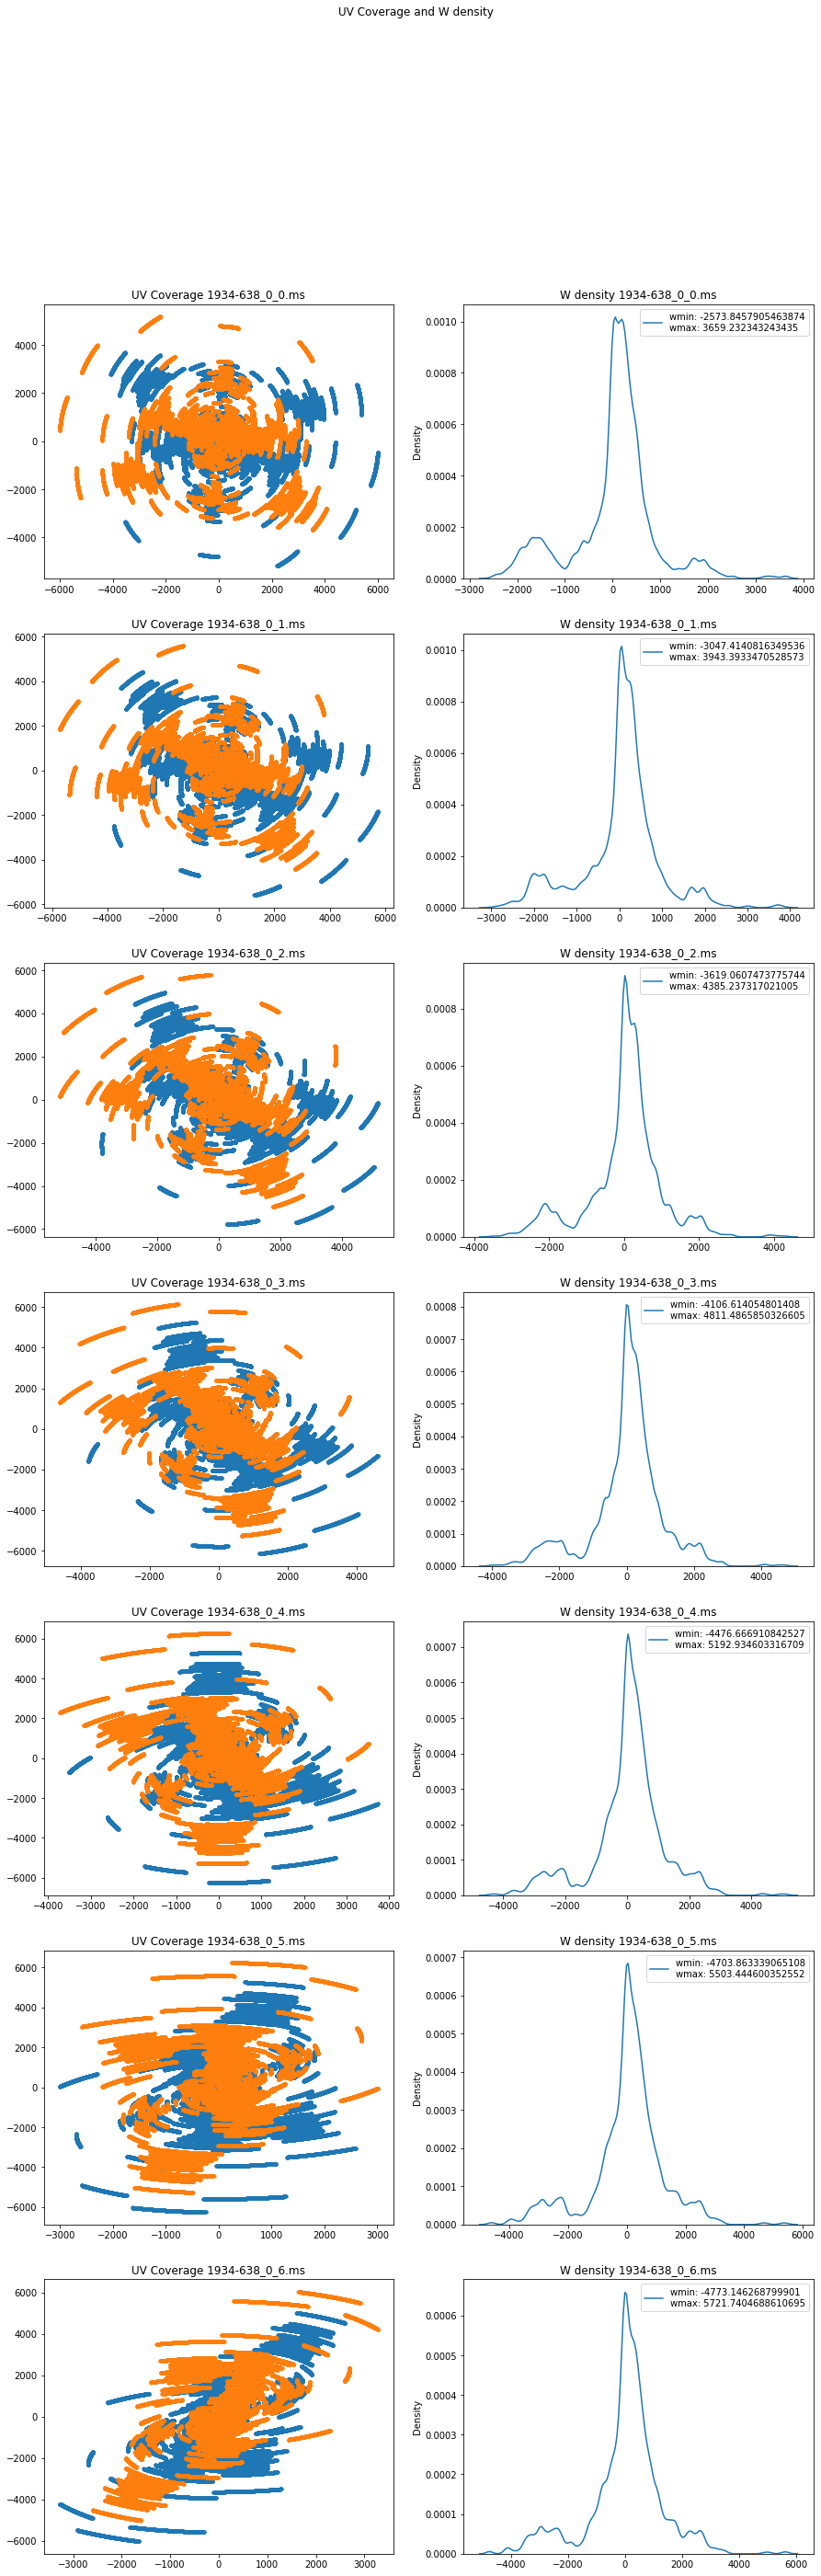

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = []
wminrange = []
wmaxrange = []

# Get variation of wscale
for time_section in range(total_duration):
    section_tbl_name = f"{source_ms}_{time_section}.ms"

    tbl.open(section_tbl_name)
    
    uvw = tbl.getcol("UVW")

    labels.append(f"t + {time_section+1}h")
    wminrange.append(np.min(uvw[2]))
    wmaxrange.append(np.max(uvw[2]))


plt.bar(labels, wminrange, 0.3, label="wmin")
plt.bar(labels, wmaxrange, 0.3, label="wmax")
plt.ylabel('W Scale')
plt.xlabel('Time')
plt.title("W Scale variation")
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
plt.legend()
# plt.tight_layout()
plt.show()

fig, ax = plt.subplots(total_duration, 2, figsize=(15, 45))
fig.suptitle("UV Coverage and W density")

# Iterating again to display uv and w density
for time_section in range(total_duration):
    section_tbl_name = f"{source_ms}_{time_section}.ms"

    tbl.open(section_tbl_name)
    
    uvw = tbl.getcol("UVW")
    ax[time_section, 0].plot(uvw[0], uvw[1], '.')
    ax[time_section, 0].plot(-uvw[0], -uvw[1], '.')
    ax[time_section, 0].set_title(f'UV Coverage {section_tbl_name}')
    
    # print(np.min(uvw[2]), np.max(uvw))
    labels.append(f"t + {time_section}h")
    wminrange.append(np.min(uvw[2]))
    wmaxrange.append(np.max(uvw[2]))
    
    sns.kdeplot(uvw[2], ax=ax[time_section, 1])
    ax[time_section, 1].set_title(f'W density {section_tbl_name}')
    ax[time_section, 1].legend([f"wmin: {np.min(uvw[2])}\nwmax: {np.max(uvw[2])}"])
    
    tbl.close()

# plt.tight_layout()
plt.show()

